# Linear MDPのサンプル効率の下界

参考
* [Confident Approximate Policy Iteration for Efficient Local Planning in qπ-realizable MDPs](https://arxiv.org/abs/2210.15755)

Linear MDPで「良い解」を達成するために必要なサンプルは最低いくつ必要でしょうか？今回はそれを導出してみます。　

表記
* $d$次元ユークリッドボール：$\mathcal{B}_d(L)=\left\{x \in \mathbb{R}^d:\|x\| \leq L\right\}$
* 特徴ベクトル：$\varphi: \mathcal{S} \times \mathcal{A} \rightarrow \mathcal{B}_d(L)$
* 状態遷移マップ：$\psi: \mathcal{S} \rightarrow \mathbb{R}^d$
    * $P\left(s^{\prime} \mid s, a\right)=\left\langle\varphi(s, a), \psi\left(s^{\prime}\right)\right\rangle$
    * $\sum_{s \in \mathcal{S}}\|\psi(s)\|_2 \leq B$
* 報酬マップ：$\theta_r \in \mathcal{B}_d(B)$
    * $r(s, a)=\left\langle\varphi(s, a), \theta_r\right\rangle$
* $(\alpha, \delta)-$ sound planner：あるMDP $M$のシミュレータを使った時、almost surelyでplannerが停止し、かつplannerが$\alpha$-optimalな方策を確率$1-\delta$以上で出力する時、$(\alpha, \delta)-$ sound plannerと言う。

このとき、次を証明します：

---

$\delta \in (0, 0.08]$, $\gamma \in [7/12, 1]$, $H=1 / (1 - \gamma)$, 
$\alpha \in\left(0,0.05 \gamma H /(1+\gamma)^2\right]$,
$d \geq 3$とする。
このとき、$(\alpha, \delta)$-soundなplannerを構築するために必要なクエリ複雑度は最低でも$\Omega\left(d^2 H^3 / \alpha^2\right)$である。

---

## ムズMDPの構築

MDPを次のように構築します：
* $\mathcal{S}=\left\{s_0, s_1\right\}$とし、$s_0$は初期状態
* $\mathcal{A}=\{ \pm 1 / \sqrt{d-2}\}^{d-2}$
    * 例えば行動の一つは$[1 / \sqrt{d-2}, -1 / \sqrt{d-2}, 1 / \sqrt{d-2}, 1 / \sqrt{d-2}, \dots]$みたいな感じ。
* 任意の$a \in \mathcal{A}$について、
$$
\varphi\left(s_0, a\right)=\left(1,0, a^{\top}\right)^{\top} \quad \text { and } \quad \varphi\left(s_1, a\right)=(0,1,0, \ldots, 0)^{\top}
$$
と特徴ベクトルを決める。

また、後で遷移確率を適当な$\beta \in \mathcal{A}$でパラメータ化する。そのため、MDPは$\beta$でパラメータ化されており、$\mathcal{M}=\left\{M_\beta \mid \beta \in \mathcal{A}\right\}$とする。
報酬ベクトルは以下で定義する：
$$\hat{\theta}_r=(1,0, \ldots, 0)^{\top}$$
よって、
* 状態$s_0$の報酬：$r_\beta\left(s_0, a\right)=\left\langle\theta_r, \varphi\left(s_0, a\right)\right\rangle=1$
* 状態$s_1$の報酬：$r_\beta\left(s_1, a\right)=\left\langle\theta_r, \varphi\left(s_0, a\right)\right\rangle=0$

なので、ずっと$s_0$にいる方策が最適。

遷移確率ベクトルは以下で定義する。$\Delta=4(1+\gamma)^2 \alpha /\left(\gamma H^2\right)$として、
$$\psi\left(s_0\right)=\left(\gamma, 0, \Delta \beta^{\top}\right)^{\top} \quad$$ 
および
$$\quad \psi\left(s_1\right)=\left(1-\gamma, 1,-\Delta \beta^{\top}\right)^{\top}$$

このとき、

$$
\begin{array}{ll}
P_\beta\left(s_0 \mid s_0, a\right)=\gamma+\Delta \beta^{\top} a, & P_\beta\left(s_1 \mid s_0, a\right)=1-\gamma-\Delta \beta^{\top} a \\
P_\beta\left(s_0 \mid s_1, a\right)=0, & P_\beta\left(s_1 \mid s_1, a\right)=1
\end{array}
$$

が成り立つ。
よって、$a=\beta$を選択すると$s_0$にいる可能性が一番高くなるので、$\beta$が最適行動。

このMDPをPythonで作ってみます。

In [110]:
import numpy as np
import jax.numpy as jnp
from itertools import product
from jax.random import PRNGKey
import jax
from typing import NamedTuple, Optional

key = PRNGKey(0)

alpha = 0.01  # 最終的な方策の性能

d = 5  # 特徴ベクトルのサイズ
S = 2  # 状態集合のサイズ
S_set = jnp.arange(S)  # 状態集合
gamma = 0.9  # 割引率
H = 1 / (1 - gamma)  # エフェクティブホライゾン

# 行動集合を作ります
A = 2 ** (d - 2)  # 行動集合のサイズ
x = [[-1 / np.sqrt(d - 2), 1 / np.sqrt(d - 2)] for _ in range(d - 2)]
A_set = jnp.array([a for a in product(*x)])  # 行動集合
assert A == len(A_set)

# MDPのパラメータβ。これが最適行動に相当します。
beta_idx = 2
beta = A_set[beta_idx]

In [111]:
# 特徴ベクトルを作ります
phi_s0 = jnp.concatenate((jnp.ones((A, 1)), jnp.zeros((A, 1))), axis=-1)
phi_s0 = jnp.concatenate((phi_s0, A_set), axis=-1)
assert jnp.all(phi_s0[0] == jnp.array([1, 0, *A_set[0]]))
assert phi_s0.shape == (A, d)

phi_s1 = jnp.zeros((A, d))
phi_s1 = phi_s1.at[:, 1].set(1.0)
assert phi_s1.shape == (A, d)

phi = jnp.concatenate((phi_s0[None, :, :], phi_s1[None, :, :]), axis=0)
assert phi.shape == (S, A, d)

In [112]:
# 報酬ベクトルを作ります
theta_r = jnp.zeros(d)
theta_r = theta_r.at[0].set(1.0)
rew = phi @ theta_r

# 遷移確率行列を作ります
Delta = 4 * (1 + gamma) ** 2 * alpha / (gamma * H ** 2)
psi_s0 = jnp.array([gamma, 0, *(Delta * beta)])
assert psi_s0.shape == (d, )
psi_s1 = jnp.array([1 - gamma, 1, *(-Delta * beta)])
assert psi_s1.shape == (d, )

P_to_s0 = phi @ psi_s0
P_to_s1 = phi @ psi_s1
P = jnp.concatenate((P_to_s0[:, :, None], P_to_s1[:, :, None]), axis=-1)
assert P.shape == (S, A, S)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します

In [113]:
# 状態集合, 行動集合, 割引率, 報酬行列, 遷移確率行列が準備できたのでMDPのクラスを作ります

class MDP(NamedTuple):
    S_set: jnp.array  # 状態集合
    A_set: jnp.array  # 行動集合
    gamma: float  # 割引率
    H: int  # エフェクティブホライゾン
    rew: jnp.array  # 報酬行列
    P: jnp.array  # 遷移確率行列
    optimal_Q: Optional[jnp.ndarray] = None  # 最適Q値

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)


H = int(1 / (1 - gamma))
mdp = MDP(S_set, A_set, gamma, H, rew, P)

print("状態数：", mdp.S)
print("行動数：", mdp.A)
print("割引率：", mdp.gamma)
print("ホライゾン：", mdp.H)

状態数： 2
行動数： 8
割引率： 0.9
ホライゾン： 10


最適方策と最適価値関数も求めておきます。

* ``compute_greedy_policy``: Q関数 ($S \times A \to \mathcal{R}$) の貪欲方策を返します
* ``compute_optimal_Q``: MDPの最適Q関数 $q_* : S \times A \to \mathcal{R}$ を返します。
* ``compute_policy_Q``: 方策 $\pi$ のQ関数 $q_\pi : S \times A \to \mathcal{R}$ を返します。
* ``compute_policy_matrix``: 方策$\pi$の行列${\Pi}^{\pi}$を返します。
* ``compute_policy_visit_sa``: 方策 $\pi$ の割引訪問頻度１${d}^\pi_\mu \in \mathbb{R}^{S\times A}$ を返します。
* ``compute_policy_visit_s``: 方策 $\pi$ の割引訪問頻度２$\bar{d}^\pi_\mu \in \mathbb{R}^{S}$ を返します。

In [114]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
import chex


@jax.jit
def compute_greedy_policy(Q: jnp.ndarray):
    """Q関数の貪欲方策を返します

    Args:
        Q (jnp.ndarray): (SxA)の行列

    Returns:
        greedy_policy (jnp.ndarray): (SxA)の行列
    """
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy


@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):
    """MDPについて、ベルマン最適作用素を複数回走らせて最適価値関数を動的計画法で計算します。
    Args:
        mdp (MDP)

    Returns:
        optimal_Q (jnp.ndarray): (SxA)の行列
    """

    def backup(optimal_Q):
        next_v = mdp.P @ optimal_Q.max(axis=1)
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.H + 100, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)


@jax.jit
def compute_policy_Q(mdp: MDP, policy: jnp.ndarray):
    """MDPと方策について、ベルマン期待作用素を複数回走らせて価値関数を動的計画法で計算します。
    Args:
        mdp (MDP)
        policy (jnp.ndarray): (SxA)の行列

    Returns:
        optimal_Q (jnp.ndarray): (SxA)の行列
    """
    S, A = policy.shape
    chex.assert_shape(policy, (mdp.S, mdp.A))

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.H + 100, body_fn, policy_Q)


@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    """
    上で定義した方策行列を計算します。方策についての内積が取りたいときに便利です。
    Args:
        policy (jnp.ndarray): (SxA)の行列

    Returns:
        policy_matrix (jnp.ndarray): (SxSA)の行列
    """
    S, A = policy.shape
    PI = policy.reshape(1, S, A)
    PI = jnp.tile(PI, (S, 1, 1))
    eyes = jnp.eye(S).reshape(S, S, 1)
    PI = (eyes * PI).reshape(S, S*A)
    return PI


@jax.jit
def compute_policy_visit_sa(mdp: MDP, policy: jnp.ndarray, init_dist: jnp.ndarray):
    """MDPと方策について、割引訪問頻度１を動的計画法で計算します。
    Args:
        mdp (MDP)
        policy (jnp.ndarray): (SxA)の行列
        init_dist (jnp.ndarray): (S) 初期状態の分布

    Returns:
        visit (jnp.ndarray): (SxA)の行列
    """
    S, A = policy.shape
    chex.assert_shape(policy, (mdp.S, mdp.A))
    Pi = compute_policy_matrix(policy)
    PPi = mdp.P.reshape(S*A, S) @ Pi 

    def backup(visit):
        next_visit = mdp.gamma * visit @ PPi
        return init_dist @ Pi + next_visit
    
    body_fn = lambda i, visit: backup(visit)
    visit = jnp.zeros(S*A)
    visit = jax.lax.fori_loop(0, mdp.H + 100, body_fn, visit)
    visit = visit.reshape(S, A)
    return visit


@jax.jit
def compute_policy_visit_s(mdp: MDP, policy: jnp.ndarray, init_dist: jnp.ndarray):
    """MDPと方策について、割引訪問頻度２を動的計画法で計算します。
    Args:
        mdp (MDP)
        policy (jnp.ndarray): (SxA)の行列
        init_dist (jnp.ndarray): (S) 初期状態の分布

    Returns:
        visit (jnp.ndarray): (S)のベクトル
    """
    S, A = policy.shape
    chex.assert_shape(policy, (mdp.S, mdp.A))
    Pi = compute_policy_matrix(policy)
    PiP = Pi @ mdp.P.reshape(S*A, S) 

    def backup(visit):
        next_visit = mdp.gamma * visit @ PiP
        return init_dist + next_visit
    
    body_fn = lambda i, visit: backup(visit)
    visit = jnp.zeros(S)
    visit = jax.lax.fori_loop(0, mdp.H + 100, body_fn, visit)
    return visit


# 動的計画法による最適価値関数
optimal_Q_DP = compute_optimal_Q(mdp)
optimal_V_DP = optimal_Q_DP.max(axis=1)
optimal_policy = compute_greedy_policy(optimal_Q_DP)
mdp = mdp._replace(optimal_Q=optimal_Q_DP)


Text(0, 0.5, 'Estimation Gap')

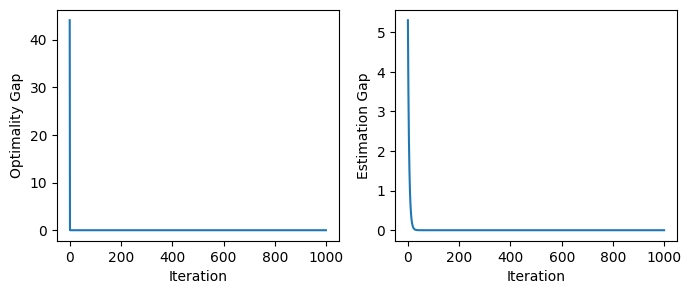

In [115]:
import matplotlib.pyplot as plt


# 価値反復法の途中経過を記録しておきます

@jax.jit
def compute_targ_Q(mdp: MDP, Q: np.ndarray):
    S, A = Q.shape
    max_Q = Q.max(axis=1).reshape(1, 1, S)
    next_v = np.sum(mdp.P * max_Q, axis=-1)
    assert next_v.shape == (S, A)
    return mdp.rew + mdp.gamma * next_v

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)


plt.figure(figsize=(8, 3))
optimality_gaps = []
estimation_gaps = []
Q_table = np.zeros((mdp.S, mdp.A))
greedy_policy = compute_greedy_policy(Q_table)

# >>>> Do value iteration >>>>
for _ in range(1000):
    estimation_gaps.append(jnp.abs(mdp.optimal_Q - Q_table).max())
    optimality_gaps.append(jnp.abs(mdp.optimal_Q - pol_Q).max())
    Q_table = compute_targ_Q(mdp, Q_table)
    greedy_policy = compute_greedy_policy(Q_table)
    pol_Q = compute_policy_Q(mdp, greedy_policy)
# <<<< Do value iteration <<<<

# >>>> Plot results >>>>
plt.subplot(1, 2, 1)
plt.plot(optimality_gaps)
plt.xlabel("Iteration")
plt.ylabel("Optimality Gap")

plt.subplot(1, 2, 2)
plt.plot(estimation_gaps)
plt.xlabel("Iteration")
plt.ylabel("Estimation Gap")
# <<<< Plot results <<<<

In [106]:
optimality_gaps

[Array(0., dtype=float32),
 Array(0.02358246, dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32),
 Array(0., dtype=float32)]

In [100]:
mdp.optimal_Q[0]

Array([49.366554, 49.36604 , 49.367073, 49.366554, 49.36604 , 49.36552 ,
       49.366554, 49.36604 ], dtype=float32)

これは難しいMDPであることを証明しましょう。
いくつか表記を導入します：

* $\mathcal{P}_\beta$：plannerとシミュレータのインタラクションで誘導される確率測度
* $i \in\{1, \ldots, d-2\}$について、
$$\operatorname{err}_i(\pi, \beta)=\sum_{a \in \mathcal{A}} \pi\left(a \mid s_0\right) I_{\operatorname{sgn}\left(a_i\right) \neq \operatorname{sgn}\left(\beta_i\right)}$$